
# Project: Sentiment Analysis of Financial News Using ULMFiT

Overview:
---------
This project employs the ULMFiT approach with fastai's AWD_LSTM model for sentiment analysis of financial news headlines. The goal is to develop a model that can automatically classify the sentiment of news headlines as positive, negative, or neutral and identify the most impactful stocks based on these sentiments.

Steps:
------
1. **Data Preparation:**
   - Utilize a large dataset containing two years of financial news headlines.
   - Prepare a labeled dataset with sentiment labels ("positive," "negative," "neutral").

2. **Language Model Fine-Tuning:**
   - Train the AWD_LSTM model on the financial news dataset to adapt it to the domain-specific vocabulary and nuances.

3. **Sentiment Classification:**
   - Fine-tune the language model to classify news headlines by sentiment using the labeled dataset.

4. **Model Deployment:**
   - Deploy the trained model to automatically scrape headlines from financial news websites.
   - Use the model to classify the sentiment of these headlines in real time.

5. **Sentiment Aggregation and Analysis:**
   - Aggregate sentiment data to identify amount of positive and negative sentiment for the stocks of interest.
   - Flag these stocks for analysts and retail investors to review.

Outcome:
--------
By leveraging domain-specific language understanding and sentiment classification, this project aims to provide actionable insights for financial analysts and retail investors.


In [1]:
#pip install fastai

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from fastai.text.all import *
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.all import plot_loss
from sklearn.model_selection import train_test_split



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fin-news-csv/fin_news.csv
/kaggle/input/language-data/reuters_headlines.csv


## 1.1 Language Model: Data Processing

In [2]:
lm_path = "../input/language-data/reuters_headlines.csv"
lm_df = pd.read_csv(lm_path)
lm_df

,Headlines,Time,Description
0,TikTok considers London and other locations for headquarters,Jul 18 2020,"TikTok has been in discussions with the UK government over the past few months to locate its headquarters in London, a source familiar with the matter said, as part of a strategy to distance itself from its Chinese ownership."
1,Disney cuts ad spending on Facebook amid growing boycott: WSJ,Jul 18 2020,"Walt Disney has become the latest company to slash its advertising spending on Facebook Inc as the social media giant faces an ad boycott over its handling of hate speech and controversial content, the Wall Street Journal reported on Saturday, citing people familiar with the situation."
2,"Trail of missing Wirecard executive leads to Belarus, Der Spiegel reports",Jul 18 2020,"Former Wirecard chief operating officer Jan Marsalek travelled to Minsk soon after he was suspended and may still be in Belarus or Russia, a German magazine reported on Saturday."
3,Twitter says attackers downloaded data from up to eight non-verified accounts,Jul 18 2020,"Twitter Inc said on Saturday that hackers were able to download account information for up to eight accounts involved in the hack of its systems this week, but said none of them were verified accounts."
4,U.S. Republicans seek liability protections as coronavirus aid battle looms,Jul 17 2020,A battle in the U.S. Congress over a new coronavirus-aid bill began on Friday as Republicans were putting the finishing touches on provisions granting liability protections for a wide range of entities resuming operations amid the pandemic.
...,...,...,...
32765,Malaysia says never hired British data firm at center of scrutiny,Mar 20 2018,"The Malaysian government and the ruling party on Tuesday denied they had ever hired Cambridge Analytica, the British data analytics firm accused of improperly harvesting personal data from millions of Facebook users."
32766,Prosecutors search Volkswagen headquarters in new emissions investigation,Mar 20 2018,German prosecutors said on Tuesday they had searched Volkswagen's headquarters as part of a new investigation into whether the carmaker had overstated the fuel efficiency of more vehicles than previously disclosed.
32767,McDonald's sets greenhouse gas reduction targets,Mar 20 2018,"McDonald's Corp on Tuesday announced an approved, science based target to cut greenhouse gas emissions and battle climate change, saying it is the first restaurant company to do so."
32768,Pratt & Whitney to deliver spare A320neo engines soon to India's IndiGo: source,Mar 20 2018,"Pratt & Whitney will soon begin deliveries of spare engines to India's IndiGo airlines, which was forced to ground eight of its Airbus A320neo aircraft last week after engine problems, a source familiar with the matter told Reuters."


In [3]:
lm_df.describe()

,Headlines,Time,Description
count,32770,32770,32770
unique,32575,852,32574
top,Take Five: World markets themes for the week ahead,Mar 19 2020,Following are five big themes likely to dominate thinking of investors and traders in the coming week and the Reuters stories related to them.
freq,12,126,25


In [53]:
#Concatenate headlines to description to create inputs with more information
lm_df["full_text"] = lm_df["Headlines"] + "; " + lm_df['Description']
lm_df.head()

,Headlines,Time,Description,full_text
0,TikTok considers London and other locations for headquarters,Jul 18 2020,"TikTok has been in discussions with the UK government over the past few months to locate its headquarters in London, a source familiar with the matter said, as part of a strategy to distance itself from its Chinese ownership.","TikTok considers London and other locations for headquarters; TikTok has been in discussions with the UK government over the past few months to locate its headquarters in London, a source familiar with the matter said, as part of a strategy to distance itself from its Chinese ownership."
1,Disney cuts ad spending on Facebook amid growing boycott: WSJ,Jul 18 2020,"Walt Disney has become the latest company to slash its advertising spending on Facebook Inc as the social media giant faces an ad boycott over its handling of hate speech and controversial content, the Wall Street Journal reported on Saturday, citing people familiar with the situation.","Disney cuts ad spending on Facebook amid growing boycott: WSJ; Walt Disney has become the latest company to slash its advertising spending on Facebook Inc as the social media giant faces an ad boycott over its handling of hate speech and controversial content, the Wall Street Journal reported on Saturday, citing people familiar with the situation."
2,"Trail of missing Wirecard executive leads to Belarus, Der Spiegel reports",Jul 18 2020,"Former Wirecard chief operating officer Jan Marsalek travelled to Minsk soon after he was suspended and may still be in Belarus or Russia, a German magazine reported on Saturday.","Trail of missing Wirecard executive leads to Belarus, Der Spiegel reports; Former Wirecard chief operating officer Jan Marsalek travelled to Minsk soon after he was suspended and may still be in Belarus or Russia, a German magazine reported on Saturday."
3,Twitter says attackers downloaded data from up to eight non-verified accounts,Jul 18 2020,"Twitter Inc said on Saturday that hackers were able to download account information for up to eight accounts involved in the hack of its systems this week, but said none of them were verified accounts.","Twitter says attackers downloaded data from up to eight non-verified accounts; Twitter Inc said on Saturday that hackers were able to download account information for up to eight accounts involved in the hack of its systems this week, but said none of them were verified accounts."
4,U.S. Republicans seek liability protections as coronavirus aid battle looms,Jul 17 2020,A battle in the U.S. Congress over a new coronavirus-aid bill began on Friday as Republicans were putting the finishing touches on provisions granting liability protections for a wide range of entities resuming operations amid the pandemic.,U.S. Republicans seek liability protections as coronavirus aid battle looms; A battle in the U.S. Congress over a new coronavirus-aid bill began on Friday as Republicans were putting the finishing touches on provisions granting liability protections for a wide range of entities resuming operations amid the pandemic.


The following code processes the data in three steps:

1. **Tokenization:**
   - In this step, each sentence is broken down into tokens based on spaces (word-based tokenization) that represent the basic units of meaning.
   - Fastai provides tools to tokenize text using pre-defined tokenizers that handle domain-specific vocabulary effectively.

2. **Numericalization:**
   - Numericalization converts tokens into numerical representations that can be processed by the model.
   - Each token is mapped to a unique integer ID based on a vocabulary built from the training corpus.
   - This step transforms the tokenized text into sequences of integers, which are the model’s input format.

3. **Creating Mini-Batches:**
   - Mini-batches are small, manageable subsets of the data used for training the model.
   - The data is divided into mini-batches to efficiently use computational resources and accelerate the training process.
   - Fastai’s `DataLoader` handles batching by grouping sequences of similar lengths and ensuring proper padding.
   - This ensures that each batch contains a uniform input size, facilitating efficient model training and reducing memory overhead.


In [5]:
#Preprocessing the data for language model
dls_lm = DataBlock(
    blocks=TextBlock.from_df('full_text', is_lm=True),
    get_x=ColReader('text')
).dataloaders(lm_df, bs=128, seq_len=80)

In [6]:
#Example of processed inputs
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj lyft pulls electric bikes in three xxup u.s . cities after complaints about braking ; xxmaj lyft xxmaj inc is removing several thousand electric bikes from service in its bike - share program in xxmaj new xxmaj york , xxmaj washington and xxmaj san xxmaj francisco because of a braking problem , the ride - hailing company said on xxmaj sunday . xxbos xxmaj big xxup u.s . investors use summer sell - off to ramp up bets","xxmaj lyft pulls electric bikes in three xxup u.s . cities after complaints about braking ; xxmaj lyft xxmaj inc is removing several thousand electric bikes from service in its bike - share program in xxmaj new xxmaj york , xxmaj washington and xxmaj san xxmaj francisco because of a braking problem , the ride - hailing company said on xxmaj sunday . xxbos xxmaj big xxup u.s . investors use summer sell - off to ramp up bets ;"
1,"xxup hp xxmaj inc , even after the xxup pc maker said it would implement a poison pill plan to shield itself against a takeover offer from the xxup u.s . printer maker . xxbos xxmaj world shares mixed as markets consider xxmaj fed , xxmaj trump impact ; xxmaj wall xxmaj street seesawed on xxmaj thursday , dragged down late in the day by technology and financial stocks , while the dollar and the xxup u.s . yield curve","hp xxmaj inc , even after the xxup pc maker said it would implement a poison pill plan to shield itself against a takeover offer from the xxup u.s . printer maker . xxbos xxmaj world shares mixed as markets consider xxmaj fed , xxmaj trump impact ; xxmaj wall xxmaj street seesawed on xxmaj thursday , dragged down late in the day by technology and financial stocks , while the dollar and the xxup u.s . yield curve flattened"


## 1.2 Language Model: Training 

In [7]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [8]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.472561,3.229416,0.402073,25.264908,01:07


In [9]:
learn.save('1epoch')

Path('models/1epoch.pth')

In [10]:
learn = learn.load('1epoch')

In [11]:
learn.unfreeze()
learn.fit_one_cycle(3, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.956341,2.937528,0.438212,18.869143,01:10
1,2.701974,2.821002,0.455381,16.793674,01:10
2,2.454476,2.816603,0.458713,16.719959,01:11


In [ ]:
# Plot the training and validation losses
plot_loss(learn)
plt.title('Learning Curve')

In [12]:
learn.save_encoder('finetuned')

## 1.3 Language Model: Prediction

The language model trained on financial news jargon has learned to predict news headlines

In [13]:
#Generate a news headline
TEXT = "Microsoft today"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]
print("\n".join(preds))

Microsoft today sees record second quarter revenue , revenue , revenue ; Microsoft Corp beat Wall Street estimates for quarterly revenue on Wednesday as it boosted quarterly revenue and revenue , sending its shares up about 5
Microsoft today faces quarterly revenue as Microsoft drops on ads ; U.S . online retailer Microsoft Corp on Thursday reported a slim gain , but the year - end forecast missed analysts ' estimates as the online


## 2.1 Classifer: Data Processing

We will now use the financial news dataset with labeled sentiments to fine-tune the language model to the task of classifying sentiments.

In [14]:
path = "../input/fin-news-csv/fin_news.csv"
df = pd.read_csv(path, 
                 names=["sentiment", "text"],
                 encoding="utf-8", encoding_errors="replace")
df

,sentiment,text
0,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
1,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said ."
2,negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported ."
3,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .
4,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales ."
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .
4842,neutral,"Rinkuskiai 's beer sales fell by 6.5 per cent to 4.16 million litres , while Kauno Alus ' beer sales jumped by 6.9 per cent to 2.48 million litres ."
4843,negative,"Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007 , including vessel sales gain of EUR 12.3 mn ."
4844,negative,"Net sales of the Paper segment decreased to EUR 221.6 mn in the second quarter of 2009 from EUR 241.1 mn in the second quarter of 2008 , while operating profit excluding non-recurring items rose to EUR 8.0 mn from EUR 7.6 mn ."


In [15]:
df.describe(include="object")

,sentiment,text
count,4846,4846
unique,3,4838
top,neutral,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sells stake in Morning Digital Design Oy Finnish IT company TJ Group Plc said on Friday 7 April that it had signed an agreement on selling its shares of Morning Digital Design Oy to Edita Oyj .
freq,2879,2


In [16]:
# First, split the data into training + validation and test sets (80% train + val, 20% test)
train_val_df, test_df = train_test_split(df, 
                                         test_size=0.2, 
                                         stratify=df['sentiment'], 
                                         random_state=42)

# Then, split the training + validation set into training and validation sets (80% train, 20% val)
train_df, val_df = train_test_split(train_val_df, 
                                    test_size=0.20, 
                                    stratify=train_val_df['sentiment'], 
                                    random_state=42)

# Print the sizes of the splits
print(f'Training set size: {len(train_df)}')
print(f'Validation set size: {len(val_df)}')
print(f'Test set size: {len(test_df)}')

Training set size: 3100
Validation set size: 776
Test set size: 970


In [17]:
# Count the number of each sentiment in the training set
train_counts = train_df['sentiment'].value_counts()
print("Training set sentiment counts:\n", train_counts)

# Count the number of each sentiment in the validation set
val_counts = val_df['sentiment'].value_counts()
print("Validation set sentiment counts:\n", val_counts)

# Count the number of each sentiment in the test set
test_counts = test_df['sentiment'].value_counts()
print("Test set sentiment counts:\n", test_counts)

Training set sentiment counts:
 sentiment
neutral     1842
positive     872
negative     386
Name: count, dtype: int64
Validation set sentiment counts:
 sentiment
neutral     461
positive    218
negative     97
Name: count, dtype: int64
Test set sentiment counts:
 sentiment
neutral     576
positive    273
negative    121
Name: count, dtype: int64


In [18]:
dls_clas = DataBlock(
    blocks=(TextBlock.from_df('text', vocab=dls_lm.vocab, seq_len=72), CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('sentiment')
).dataloaders(train_df, valid_df=val_df, bs=128)

In [19]:
dls_clas.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj the report profiles xxunk companies including many key and niche players worldwide such as xxmaj black & xxmaj xxunk xxmaj corporation , xxmaj xxunk xxmaj corporation , xxmaj xxunk xxmaj brands , xxmaj inc . , xxmaj xxunk xxmaj outdoor xxmaj products xxmaj inc . , xxup xxunk xxmaj group , xxmaj xxunk xxmaj technologies , xxmaj inc . , xxmaj the xxmaj xxunk xxunk - xxunk xxmaj company , and xxmaj van xxmaj group , xxmaj inc . .",neutral
1,"xxbos xxmaj body xxup xxunk xxmaj vostok also owns stakes in power sales companies xxunk ( xxup xxunk : xxup xxunk ) ( xxunk % ) , xxmaj xxunk ( 100 % ) , xxmaj xxunk ( xxup xxunk : xxup xxunk ) xxmaj body ( xxunk % ) and xxmaj xxunk xxmaj power xxmaj sales xxmaj company ( xxup xxunk : xxup xxunk ) ( xxunk % ) , all xxunk it received from the distribution balance .",neutral
2,"xxbos xxmaj the xxmaj annual xxmaj general xxmaj meeting approved that the yearly remuneration for the members of the xxmaj board of xxmaj directors xxunk remain at xxup xxunk 40 . xxrep 3 0 for the xxmaj chairman of the xxmaj board , xxup xxunk 30 . xxrep 3 0 for the xxmaj deputy xxmaj chairman of the xxmaj board and xxup xxunk 20 . xxrep 3 0 for other members of the xxmaj board .",neutral


## 2.2 Classifier: Fine-tuning

**Fine-Tuning for Classification:**
   - In this step, we adapt the pre-trained model to our specific task: sentiment classification of financial news headlines.
   - We freeze most of the first layers of the recurrent neural net and replace the original head (output layer) of the model with a new one tailored for our task: a classifier with three output classes: positive, negative, and neutral.
   - This allows the model to learn the specific nuances of financial sentiment while retaining its general language understanding.

**Benefits:**
- **Reduced Training Time:** By using a pre-trained model, we significantly reduce the time and computational resources needed compared to training a model from scratch.
- **Improved Performance:** Leveraging the pre-existing knowledge helps the model perform better on the new task, especially when dealing with limited labeled data.

In [20]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5,
                                     metrics=accuracy).to_fp16()

In [21]:
learn = learn.load_encoder('finetuned')

### Training Techniques Used

#### Discriminative Fine-Tuning
Discriminative fine-tuning is a technique that applies different learning rates to different layers of a neural network during the fine-tuning process. This approach allows for more nuanced training, where layers closer to the output are updated more aggressively, while the earlier layers, which capture more general features, are updated more conservatively.

**Application in This Project with Slanted Triangular Learning Rates:**
- **Initial Training:** When fine-tuning the pre-trained AWD_LSTM model for sentiment classification, the earlier layers of the model, which have already learned general language features, are frozen or trained with a lower learning rate. This preserves the useful features learned during the pre-training phase.
- **Layer-Specific Learning Rates:** The later layers, which are more specific to the sentiment classification task, are trained with a higher learning rate. This allows these layers to adapt quickly to the new task-specific patterns and improve performance on the classification problem.

**Benefits:**
- **Faster Convergence:** By using slanted triangular learning rates, the model converges faster and avoids the pitfalls of a fixed learning rate.
- **Improved Performance:** Discriminative fine-tuning ensures that task-specific layers learn quickly and effectively, enhancing overall model performance.

#### Summary

In this project, discriminative fine-tuning and slanted triangular learning rates were employed to enhance the fine-tuning process of the AWD_LSTM model for sentiment classification. Discriminative fine-tuning allowed for effective layer-specific learning, while slanted triangular learning rates improved convergence and model performance.


In [22]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.905168,0.794756,0.638710,00:03


In [23]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.724630,0.646694,0.732258,00:02


In [24]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.614951,0.614170,0.740323,00:02


In [25]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.479675,0.576563,0.775806,00:02
1,0.457820,0.580997,0.770968,00:02


In [26]:
learn.export('fin_news_classifier_model.pkl')

In [ ]:
learn.load_learner('fin_news_classifier_model.pkl', cpu=False)

## 2.3 Classifier: Evaluation

**Purpose of the Test Set:**
- **Unbiased Evaluation:** The test set helps determine how well the model generalizes to real-world data that it has not encountered during training. This is essential for understanding the model's true performance.
- **Performance Metrics:** By evaluating the model on the test set, we can compute various performance metrics such as accuracy, precision, recall, and F1-score, which provide insights into how well the model is performing across different aspects of classification.

**Performance Metrics:**
   - **Accuracy:** Measures the proportion of correctly classified headlines out of all test samples.
   - **Precision, Recall, and F1-Score:** Evaluate the model's performance for each class (positive, negative, neutral) in terms of its ability to correctly identify each sentiment.
   - **Confusion Matrix:** Provides a detailed view of the classification performance, showing the number of true positives, true negatives, false positives, and false negatives.


In [27]:
test_df

,sentiment,text
2108,neutral,"Following the payment made in April , the company has a total of EUR 23.0 million in loans from financial institutions ."
4276,neutral,The share subscription period for C options will commence on 1 September 2008 and expire on 31 March 2011 .
478,neutral,Aspocomp intends to set up a plant to manufacture printed circuit boards with an investment of Rs310 crore .
810,positive,Finnish Rautaruukki has been awarded a contract to supply and install steel superstructures for the Partihallsf+�rbindelsen bridge in Gothenburg in Sweden .
4648,negative,Finnish Bank of +_land reports its operating profit fell to EUR 4.9 mn in the third quarter of 2007 from EUR 5.6 mn in the third quarter of 2006 .
...,...,...
1567,positive,"Nokia will continue to invest in future development of Qt for the benefit of all users , both Commercial and LGPL ."
997,positive,Uponor improved its performance in spite of the decrease in residential construction in the US .
307,positive,Total operating revenue grew by 27.6 % year-on-year to EUR61m .
518,positive,"The equipment will expand container handling capacity at Namibia 's main port of Walvis Bay , on the west coast ."


In [28]:
# Save the DataFrame as a CSV file
test_df.to_csv('test_df_saved.csv', index=False)

In [29]:
#Process the test set
test_dl = learn.dls.test_dl(test_df, with_labels=True, bs=128)

In [31]:
# Get predictions and calculate metrics on the test set
preds, targs = learn.get_preds(dl=test_dl)

              precision    recall  f1-score   support

    negative       0.68      0.66      0.67       121
     neutral       0.83      0.83      0.83       576
    positive       0.67      0.67      0.67       273

    accuracy                           0.76       970
   macro avg       0.73      0.72      0.72       970
weighted avg       0.76      0.76      0.76       970



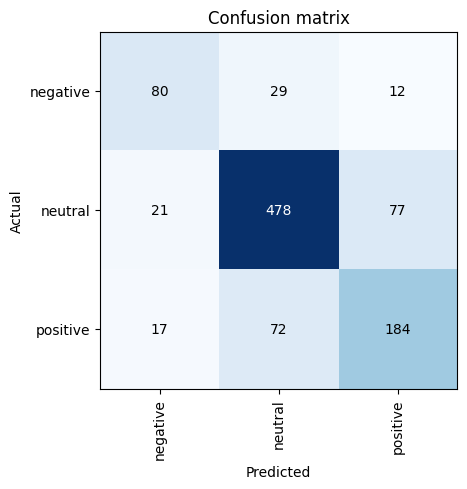

In [33]:
# Evaluate using ClassificationInterpretation
from fastai.interpret import ClassificationInterpretation
interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interp.print_classification_report()
interp.plot_confusion_matrix()

## Model Evaluation and Improvement Plan

### Model Evaluation

- **Overall Accuracy:** The model achieves an accuracy of 0.76, meaning it correctly classifies 76% of the headlines overall. While this is relatively good, it may mask some issues related to class imbalance.

- **F1 Scores:**
  - **Negative Sentiment:** The F1 score is 0.67, indicating moderate performance in classifying negative sentiments.
  - **Neutral Sentiment:** The F1 score is 0.83, the highest among the three classes, suggesting better performance with neutral headlines.
  - **Positive Sentiment:** The F1 score is 0.67, showing that the model has difficulty with positive sentiment classification.

- **Confusion Matrix Insights:** The model particularly struggles with positive sentiment, frequently misclassifying positive headlines as neutral and vice versa. This confusion highlights the model’s challenge in distinguishing between positive and neutral sentiments, likely due to the class imbalance.

### Improvement Strategies

1. **Address Class Imbalance:**
   - **Resampling Techniques:** Use oversampling techniques like SMOTE (Synthetic Minority Over-sampling Technique) to increase the number of positive and negative samples, or undersample the neutral class to balance the dataset.
   - **Class Weights:** Adjust class weights in the loss function to give more importance to minority classes (positive and negative) during training. This helps the model focus more on these classes.

2. **Enhance Model Training:**
   - **Augmentation:** Apply data augmentation techniques to create variations of minority class examples, improving the model’s robustness.
   - **Fine-Tuning:** Experiment with further fine-tuning the model, particularly focusing on improving its performance on positive sentiment. Also, train the language model on more financial news data would help improve its vocabulary and predictive performance.

4. **Model Architecture Adjustments:**
   - **Ensemble Methods:** Combine predictions from multiple models (e.g., logistic regression, random forest) with your current model to improve performance, particularly on challenging classes.
   - **Hyperparameter Tuning:** Optimize hyperparameters using grid search or random search to find the best settings for handling imbalanced data. 

5. **Data Quality and Feature Engineering:**
   - **Feature Engineering:** Explore additional features or embeddings that might capture sentiment nuances better.
   - **Text Preprocessing:** Revisit text preprocessing steps to ensure they are optimal for the model, including handling domain-specific jargon.

## Conclusion

While the model demonstrates solid overall accuracy, the F1 scores and confusion matrix reveal significant challenges with classifying positive sentiments and handling class imbalance. Implementing strategies to address these issues should improve the model’s performance across all sentiment categories and make it more reliable in real-world applications.
